In [16]:
import sys
import gym
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import random
%matplotlib inline
plt.style.use('ggplot')
np.set_printoptions(precision=3, linewidth=120)

In [17]:
# Create an environment and set random seed
env = gym.make('MountainCar-v0')
env.seed(505);

In [18]:
state = env.reset()
score = 0
for t in range(200):
    action = env.action_space.sample()
    env.render()
    state, reward, done, _ = env.step(action)
    score += reward
    if done:
        break 
print('Final score:', score)
env.close()

Final score: -200.0


In [19]:
# Explore state (observation) space
print("State space:", env.observation_space)
print("- low:", env.observation_space.low)
print("- high:", env.observation_space.high)

State space: Box(2,)
- low: [-1.2  -0.07]
- high: [0.6  0.07]


In [20]:
# Generate some samples from the state space 
print("State space samples:")
print(np.array([env.observation_space.sample() for i in range(10)]))

State space samples:
[[-5.134e-01 -3.308e-02]
 [-1.943e-01 -4.116e-02]
 [-7.059e-01  5.910e-02]
 [-2.260e-02  2.314e-02]
 [-6.664e-01 -1.630e-02]
 [ 5.470e-01  5.629e-02]
 [-9.935e-01  2.523e-02]
 [ 8.153e-02 -5.825e-02]
 [ 4.216e-01 -2.025e-02]
 [-3.005e-01 -4.939e-04]]


In [21]:
print("Action space:", env.action_space)

# Generate some samples from the action space
print("Action space samples:")
print(np.array([env.action_space.sample() for i in range(10)]))

Action space: Discrete(3)
Action space samples:
[0 0 0 1 0 2 0 2 2 2]


In [22]:
def create_uniform_grid(low, high, bins=(10, 10)):
    """Define a uniformly-spaced grid that can be used to discretize a space.
    
    Parameters
    ----------
    low : array_like
        Lower bounds for each dimension of the continuous space.
    high : array_like
        Upper bounds for each dimension of the continuous space.
    bins : tuple
        Number of bins along each corresponding dimension.
    
    Returns
    -------
    grid : list of array_like
        A list of arrays containing split points for each dimension.
    """
    grid = []
    for i in range(len(bins)):
        step = (high[i] - low[i]) / bins[i]
        grid.append(np.linspace(low[i]+step, high[i] ,endpoint=False, num=bins[i]-1))
    
    return grid
        


In [23]:
def discretize(sample, grid):
    """Discretize a sample as per given grid.
    
    Parameters
    ----------
    sample : array_like
        A single sample from the (original) continuous space.
    grid : list of array_like
        A list of arrays containing split points for each dimension.
    
    Returns
    -------
    discretized_sample : array_like
        A sequence of integers with the same number of dimensions as sample.
    """
    dim = len(np.transpose(sample))
    discrete = np.zeros((dim,), dtype=int)
    for j in range(dim):
            discrete[j] = int(np.digitize(sample[j], grid[j]))
            
    return discrete
            
            
    

In [24]:
import matplotlib.collections as mc

def visualize_samples(samples, discretized_samples, grid, low=None, high=None):
    """Visualize original and discretized samples on a given 2-dimensional grid."""

    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Show grid
    ax.xaxis.set_major_locator(plt.FixedLocator(grid[0]))
    ax.yaxis.set_major_locator(plt.FixedLocator(grid[1]))
    ax.grid(True)
    
    # If bounds (low, high) are specified, use them to set axis limits
    if low is not None and high is not None:
        ax.set_xlim(low[0], high[0])
        ax.set_ylim(low[1], high[1])
    else:
        # Otherwise use first, last grid locations as low, high (for further mapping discretized samples)
        low = [splits[0] for splits in grid]
        high = [splits[-1] for splits in grid]

    # Map each discretized sample (which is really an index) to the center of corresponding grid cell
    grid_extended = np.hstack((np.array([low]).T, grid, np.array([high]).T))  # add low and high ends
    grid_centers = (grid_extended[:, 1:] + grid_extended[:, :-1]) / 2  # compute center of each grid cell
    locs = np.stack(grid_centers[i, discretized_samples[:, i]] for i in range(len(grid))).T  # map discretized samples

    ax.plot(samples[:, 0], samples[:, 1], 'o')  # plot original samples
    ax.plot(locs[:, 0], locs[:, 1], 's')  # plot discretized samples in mapped locations
    ax.add_collection(mc.LineCollection(list(zip(samples, locs)), colors='orange'))  # add a line connecting each original-discretized sample
    ax.legend(['original', 'discretized'])



In [ ]:
# Default, 10 bins
visualize_samples(samples, discretized_samples, grid, low, high)


In [13]:
# Create a grid to discretize the state space
state_grid = create_uniform_grid(env.observation_space.low, env.observation_space.high, bins=(10, 10))

/home/t/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


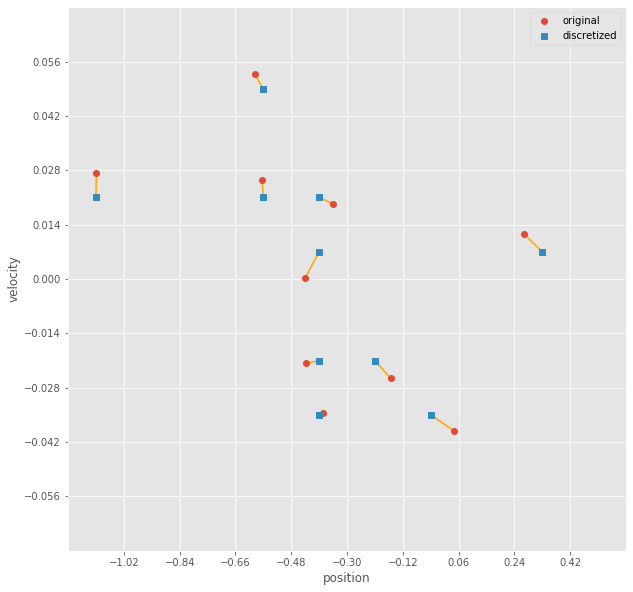

In [14]:
# Obtain some samples from the space, discretize them, and then visualize them
state_samples = np.array([env.observation_space.sample() for i in range(10)])
discretized_state_samples = np.array([discretize(sample, state_grid) for sample in state_samples])
visualize_samples(state_samples, discretized_state_samples, state_grid,
                  env.observation_space.low, env.observation_space.high)
plt.xlabel('position'); plt.ylabel('velocity');  # axis labels for MountainCar-v0 state space

In [35]:
def q_learning_discrete(env, num_episodes, alpha=0.02, discount_factor=0.99, bins = (10,10)):
    """
    Q learning algorithm, off-polics TD control. Finds optimal gready policies
    Args:
    - env: Given environment to solve
    - num_episodes: Number of episodes to learn
    - alpha: learning rate
    - discount factor: weight/importance given to future rewards
    - epsilon: probability of taking random action. 
             We are using decaying epsilon, 
             i.e high randomness at beginning and low towards end
    Returns:
    - Optimal Q
    """
     
    # decaying epsilon, i.e we will divide num of episodes passed
    epsilon = 1.0
    score = 0.0
    epsilon_decay_rate=0.9995
    scores = []
    avg_score = 0
    max_avg_score = -np.inf
    state_grid = create_uniform_grid(env.observation_space.low, env.observation_space.high, bins)
    q_table = np.zeros((env.action_space.n, bins[0], bins[1])) 
    
    for i_episode in range(num_episodes):
            # reset the env
            state = env.reset()
            total_reward = 0
            discrete_state = np.array(discretize(state, state_grid)) 
            
            # itertools.count() has similar to 'while True:'
            for t in itertools.count():
                # generate a random num between 0 and 1 e.g. 0.35, 0.73 etc..
                # if the generated num is smaller than epsilon, we follow exploration policy 
                if random.uniform(0, 1) < epsilon:
                    action = env.action_space.sample()
                    # select a random action from set of all actions
                else:
                    action = np.argmax(q_table[:, discrete_state[0], discrete_state[1]])
                    # if the generated num is greater than epsilon, we follow exploitation policy
                    # select an action with highest value for current state
                    
                next_state, reward, is_finished, info = env.step(action)
                discrete_next_state = np.array(discretize(next_state, state_grid))
                
                # apply selected action, collect values for next_state and reward
                old_value = q_table[action, discrete_state[0], discrete_state[1]]
                next_max  = np.max(q_table[:, discrete_next_state[0], discrete_next_state[1]])
                new_value = old_value+(alpha*(reward+(discount_factor*next_max)-old_value))
                # Update the Q table, alpha is the learning rate
                q_table[action, discrete_state[0], discrete_state[1]] = new_value
                
                # break if done, i.e. if end of this episode
                if is_finished:
                    scores.append(total_reward)
                    if len(scores) > 100:
                        avg_score = np.mean(scores[-100:])
                        if avg_score > max_avg_score:
                            max_avg_score = avg_score
                    if i_episode % 100 == 0:
                        #print("\rEpisode {}/{} | Max Average Score: {}".format(i_episode, num_episodes, max_avg_score), end="")
                        sys.stdout.flush()
                    break
                    
                # make the next_state into current state as we go for next iteration
                discrete_state = discrete_next_state
                #env.render()
                total_reward += reward
                    
            if epsilon > 0.1:
                epsilon *= epsilon_decay_rate
                
                
    final_s = 0
    final_s = avg_score
    #print("Training finished.\n")
    
    return q_table, scores, max_avg_score    # return optimal Q

Episode 49900/50000 | Max Average Score: -137.41Training finished.

Final score is  -180.53
[[[-69.845 -78.258 -79.079 -79.382 -79.181 -78.889 -77.955 -76.468   0.      0.   ]
  [-77.232 -79.169 -79.988 -80.366 -80.451 -80.483 -79.696 -77.623 -75.904   0.   ]
  [-78.313 -80.135 -81.402 -83.084 -85.139 -85.209 -82.39  -78.694 -77.015  -2.191]
  [-78.495 -80.493 -81.885 -83.728 -87.564 -88.223 -84.617 -79.923 -76.859 -71.796]
  [-78.307 -80.534 -81.848 -83.172 -87.637 -87.851 -85.096 -80.523 -76.653 -73.013]
  [-69.388 -79.788 -80.939 -82.631 -83.648 -84.35  -84.121 -79.506 -75.882 -72.528]
  [  0.    -78.169 -80.536 -81.32  -82.588 -82.932 -81.582 -76.562 -74.242 -56.828]
  [  0.      0.    -79.276 -81.004 -81.594 -81.54  -77.932 -73.241 -70.186   0.   ]
  [  0.      0.     -2.596 -79.343 -80.629 -78.271 -73.204 -69.342 -55.572   0.   ]
  [  0.      0.      0.     -1.449 -73.978 -72.821 -69.946 -66.525 -45.652   0.   ]]

 [[-69.909 -78.259 -79.076 -79.38  -79.175 -78.867 -77.905 -76.487

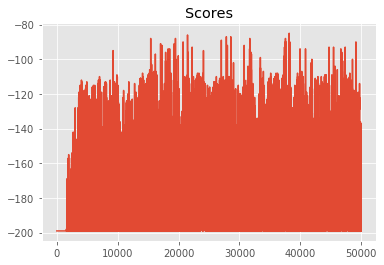

In [105]:
Q, scores, max_avg_score = q_learning_discrete(env, 20000)

In [ ]:
plt.plot(scores); plt.title("Scores");

In [59]:
def plot_scores(scores, rolling_window=100):
    """Plot scores and optional rolling mean using specified window."""
    plt.figure()
    plt.plot(scores); plt.title("Scores");
    rolling_mean = pd.Series(scores).rolling(rolling_window).mean()
    plt.plot(rolling_mean);
    plt.show()
    return rolling_mean


In [66]:
def test_algorithm(env, Q, render = False, bins = (10,10)):
    """
    Test script for Q function
    Args:
    - env: Given environment to test Q function
    - Q: Q function to verified
    Returns:
    - Total rewards for one episode
    """
    state_grid = create_uniform_grid(env.observation_space.low, env.observation_space.high, bins)
    state = env.reset()
    discrete_state = np.array(discretize(state, state_grid)) 
    
    total_reward = 0
    while True:
        # selection the action with highest values i.e. best action
        action = np.argmax(Q[:, discrete_state[0], discrete_state[1]])
        # apply selected action
        next_state, reward, done, _ = env.step(action)
        next_state_discrete = np.array(discretize(next_state, state_grid))
        
        # render environment
        if render == True:
            env.render()
    
        # calculate total reward
        total_reward += reward
        if done:
            break
            
        discrete_state = next_state_discrete
        
    return total_reward

[  100 10080 20060 30040 40020 50000]
Number of episodes:  100


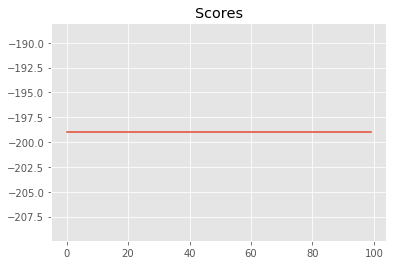

Number of episodes:  10080


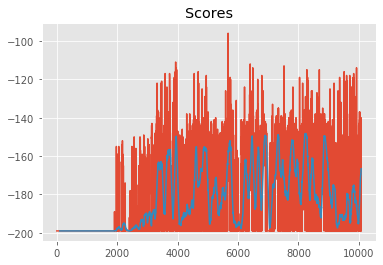

Number of episodes:  20060


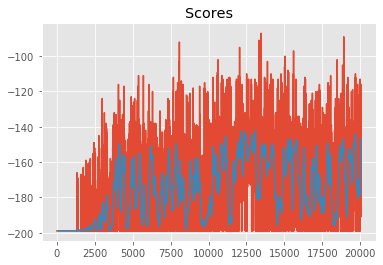

Number of episodes:  30040


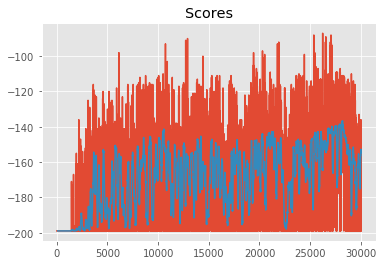

Number of episodes:  40020


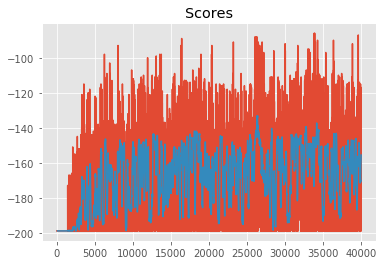

Number of episodes:  50000


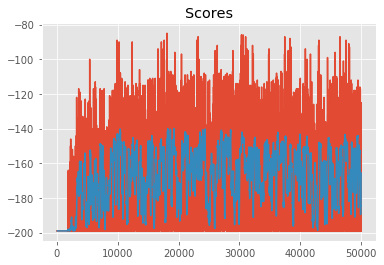

Text(0, 0.5, 'Maximum average score in every episode number')

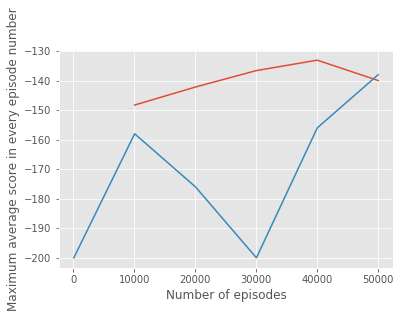

In [62]:
"First, let's change the number of episodes and see its effect"

max_avg_score_training = []
score_testing = []
episodes = np.linspace(100,50000, num = 6, dtype=int)
print(episodes)
for episode in episodes:
    Q, scores, max_avg_score = q_learning_discrete(env, episode)
    max_avg_score_training.append(max_avg_score)
    score_test = test_salgorithm(env, Q)
    score_testing.append(score_test)
    print ("Number of episodes: ", episode)
    plot_scores(scores)

plt.plot(episodes, max_avg_score_training)
plt.xlabel('Number of episodes')
plt.ylabel('Maximum average score in every episode number') 
plt.plot(episodes, score_testing)
plt.xlabel('Number of episodes')
plt.ylabel('Maximum average score in every episode number') 

In [63]:
print("Average score in training", max_avg_score_training)
print("testing reward", score_testing)

Average score in training [-inf, -148.26, -142.16, -136.6, -133.07, -139.97]
testing reward [-200.0, -158.0, -176.0, -200.0, -156.0, -138.0]


In [81]:
Q, scores, max_avg_score = q_learning_discrete(env, 10000)


In [80]:
test_algorithm(env, Q, render = True)
env.close()

Number of bins:  5


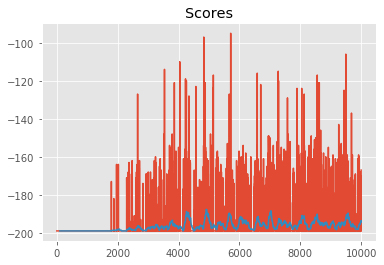

Number of bins:  10


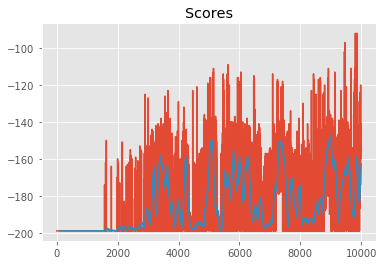

Number of bins:  15


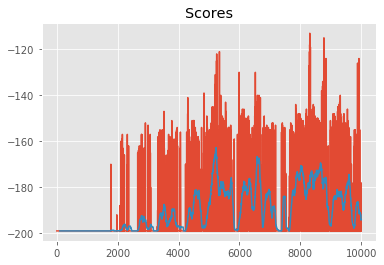

Number of bins:  20


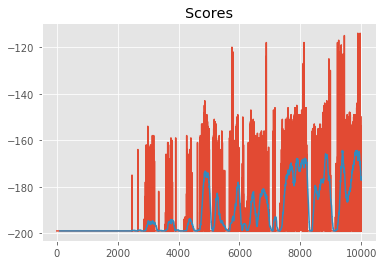

Number of bins:  25


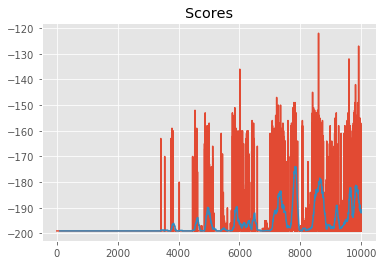

Number of bins:  30


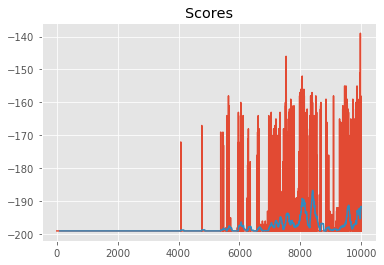

Number of bins:  35


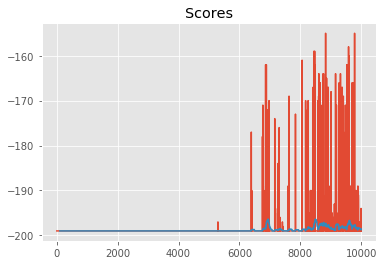

Text(0, 0.5, 'Maximum average score in every episode number')

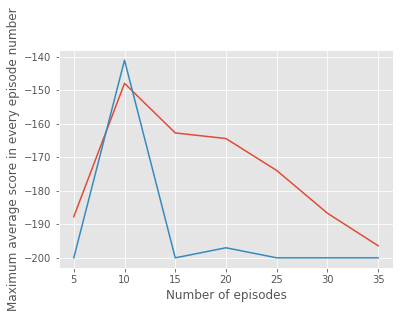

In [88]:
"Second, we will fix 10000 iterations as it 50000 will require high computational power, and will vary bins"

max_avg_score_training = []
score_testing = []
bins_arr = np.linspace(5,35, num = 3, dtype=int)
for Bins in bins_arr:
    Q, scores, max_avg_score = q_learning_discrete(env, 10000, bins=(Bins,Bins))
    max_avg_score_training.append(max_avg_score)
    score_test = test_algorithm(env, Q, bins=(Bins,Bins))
    score_testing.append(score_test)
    print ("Number of bins: ", Bins)
    plot_scores(scores)

plt.plot(bins_arr, max_avg_score_training)
plt.xlabel('Number of episodes')
plt.ylabel('Maximum average score in every episode number') 
plt.plot(bins_arr, score_testing)
plt.xlabel('Number of episodes')
plt.ylabel('Maximum average score in every episode number') 

In [89]:
print("Average score in training", max_avg_score_training)
print("testing reward", score_testing)

Average score in training [-187.71, -147.92, -162.72, -164.4, -173.93, -186.69, -196.39]
testing reward [-200.0, -141.0, -200.0, -197.0, -200.0, -200.0, -200.0]


Number of bins:  5


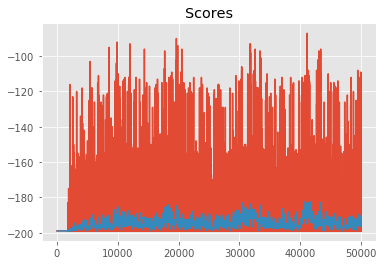

Number of bins:  20


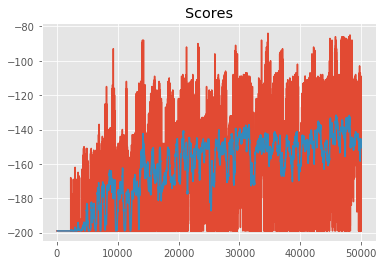

Number of bins:  35


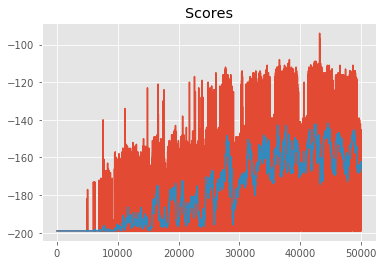

Text(0, 0.5, 'Maximum average score in every episode number')

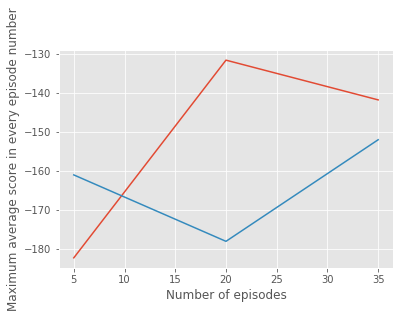

In [90]:
"Second, we will fix 50000 iterations for 3 trials, and will vary bins"

max_avg_score_training = []
score_testing = []
bins_arr = np.linspace(5,35, num = 3, dtype=int)
for Bins in bins_arr:
    Q, scores, max_avg_score = q_learning_discrete(env, 50000, bins=(Bins,Bins))
    max_avg_score_training.append(max_avg_score)
    score_test = test_algorithm(env, Q, bins=(Bins,Bins))
    score_testing.append(score_test)
    print ("Number of bins: ", Bins)
    plot_scores(scores)

plt.plot(bins_arr, max_avg_score_training)
plt.xlabel('Number of episodes')
plt.ylabel('Maximum average score in every episode number') 
plt.plot(bins_arr, score_testing)
plt.xlabel('Number of episodes')
plt.ylabel('Maximum average score in every episode number') 

Average score in training [-182.22, -131.63, -141.8]
testing reward [-161.0, -178.0, -152.0]


Text(0, 0.5, 'Maximum average score in every episode number')

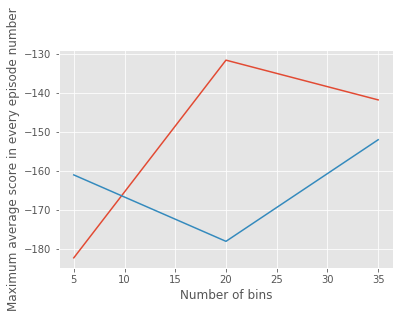

In [91]:
print("Average score in training", max_avg_score_training)
print("testing reward", score_testing)
plt.plot(bins_arr, max_avg_score_training)
plt.xlabel('Number of bins')
plt.ylabel('Maximum average score in every episode number') 
plt.plot(bins_arr, score_testing)
plt.xlabel('Number of bins')
plt.ylabel('Maximum average score in every episode number') 

Number of bins:  35


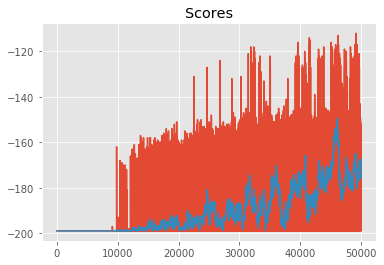

ValueError: x and y must have same first dimension, but have shapes (3,) and (4,)

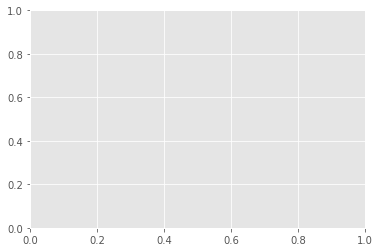

In [92]:
"Second, we will fix 50000 iterations for 3 trials, and will vary bins"

Q, scores, max_avg_score = q_learning_discrete(env, 50000, bins=(45,45))
max_avg_score_training.append(max_avg_score)
score_test = test_algorithm(env, Q, bins=(45,45))
score_testing.append(score_test)
print ("Number of bins: ", Bins)
plot_scores(scores)



Text(0, 0.5, 'Maximum average score in every episode number')

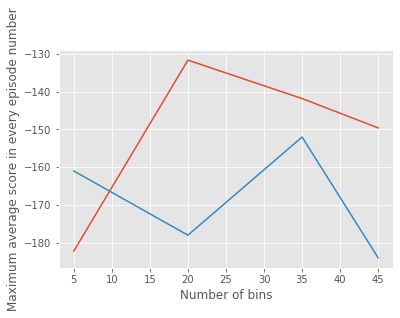

In [93]:
bins_arr = [5,20,35,45]
plt.plot(bins_arr, max_avg_score_training)
plt.xlabel('Number of bins')
plt.ylabel('Maximum average score in every episode number') 
plt.plot(bins_arr, score_testing)
plt.xlabel('Number of bins')
plt.ylabel('Maximum average score in every episode number') 

In [94]:
print("Average score in training", max_avg_score_training)
print("testing reward", score_testing)

Average score in training [-182.22, -131.63, -141.8, -149.58]
testing reward [-161.0, -178.0, -152.0, -184.0]


Learning Rate:  0.0002


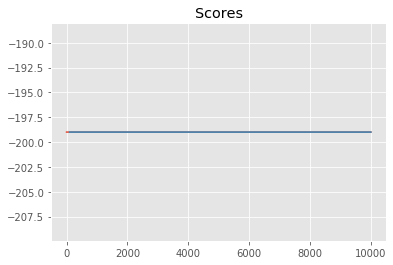

Learning Rate:  0.002


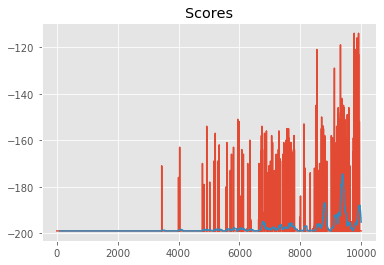

Learning Rate:  0.02


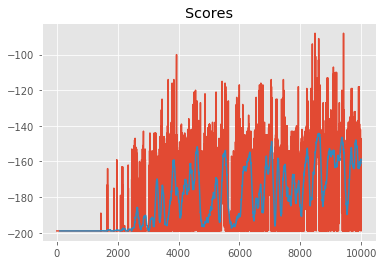

Learning Rate:  0.2


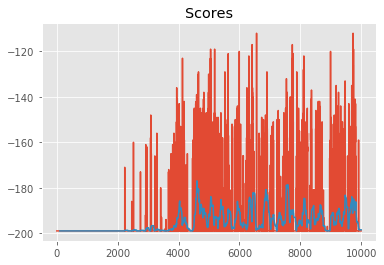

Learning Rate:  0.3


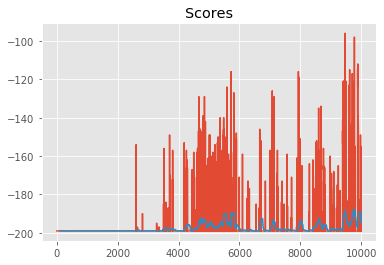

Learning Rate:  0.4


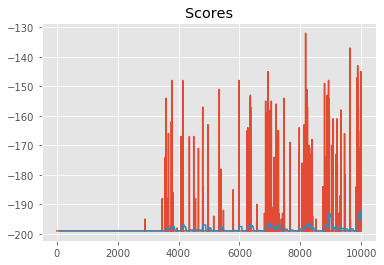

Learning Rate:  0.5


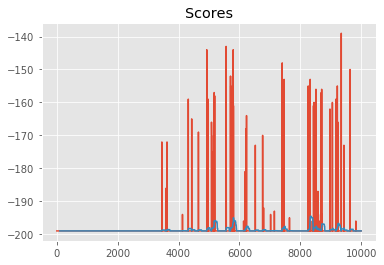

Learning Rate:  0.6


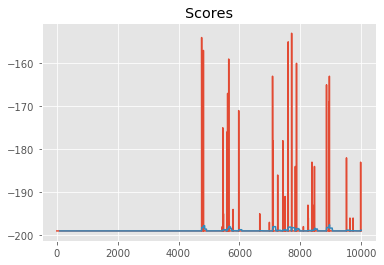

Learning Rate:  0.7


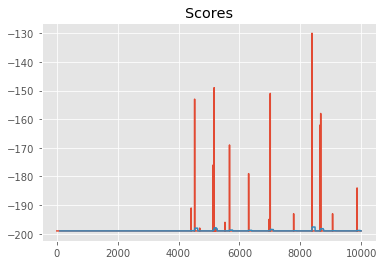

Learning Rate:  0.85


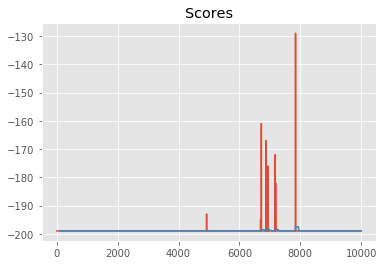

ValueError: x and y must have same first dimension, but have shapes (4,) and (10,)

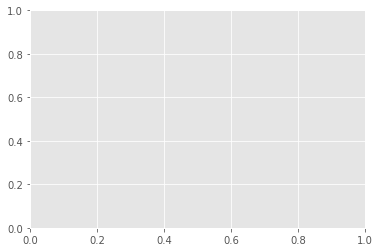

In [99]:
"Second, we will fix 10000 iterations for 15 trials, and will vary learning rates"

max_avg_score_training = []
score_testing = []
alphas = [0.0002, 0.002,0.02, 0.2, 0.3 ,0.4, 0.5, 0.6, 0.7, 0.85]

for alpha in alphas:
    Q, scores, max_avg_score = q_learning_discrete(env, 10000, alpha = alpha)
    max_avg_score_training.append(max_avg_score)
    score_test = test_algorithm(env, Q)
    score_testing.append(score_test)
    print ("Learning Rate: ", alpha)
    plot_scores(scores)

plt.plot(alphas, max_avg_score_training)
plt.xlabel('Learning Rate')
plt.ylabel('Maximum average score in every episode number') 
plt.plot(alphas, score_testing)
plt.xlabel('Learning Rate')
plt.ylabel('Maximum average score in every episode number') 

Text(0, 0.5, 'Maximum average score in every episode number')

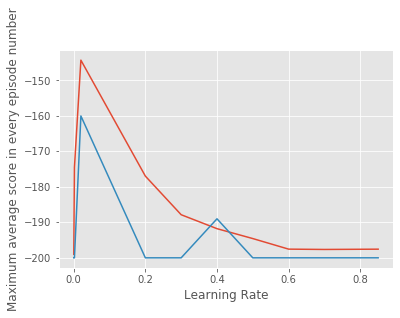

In [100]:
plt.plot(alphas, max_avg_score_training)
plt.xlabel('Learning Rate')
plt.ylabel('Maximum average score in every episode number') 
plt.plot(alphas, score_testing)
plt.xlabel('Learning Rate')
plt.ylabel('Maximum average score in every episode number') 

In [102]:
print("Average score in training", max_avg_score_training)
print("testing reward", score_testing)
print("Alphas", alphas)

Average score in training [-199.0, -174.49, -144.27, -176.96, -187.85, -191.78, -194.57, -197.55, -197.64, -197.56]
testing reward [-200.0, -200.0, -160.0, -200.0, -200.0, -189.0, -200.0, -200.0, -200.0, -200.0]
Alphas [0.0002, 0.002, 0.02, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.85]


In [ ]:
"Second, we will fix 10000 iterations for 15 trials, and will vary learning rates"

max_avg_score_training = []
score_testing = []
alphas = np.linspace(0.019, 0.03, num=10)

for alpha in alphas:
    Q, scores, max_avg_score = q_learning_discrete(env, 10000, alpha = alpha)
    max_avg_score_training.append(max_avg_score)
    score_test = test_algorithm(env, Q)
    score_testing.append(score_test)
    print ("Learning Rate: ", alpha)
    plot_scores(scores)

plt.plot(bins_arr, max_avg_score_training)
plt.xlabel('Learning Rate')
plt.ylabel('Maximum average score in every episode number') 
plt.plot(bins_arr, score_testing)
plt.xlabel('Learning Rate')
plt.ylabel('Maximum average score in every episode number') 